## Final Project of Big Data

## Import Libraries

In [157]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
#sc = SparkContext('local', 'pyspark') 
sqlContext = SQLContext(sc)

## Load Data Set

In [158]:
loadPath = "../dataset/lending/loan.csv"
dataload = sqlContext.read.csv(loadPath, header='true')
dataload.createOrReplaceTempView("loancredit")
#dataload.cache()

## Show Schema

In [ ]:
dataload.printSchema()

In [ ]:
dataload.count()

# Clean data

## Check for duplications

In [ ]:
print('Count of rows: {0}'.format(dataload.count()))
print('Count of distinct rows: {0}'.format(dataload.distinct().count()))

The amount of rows is same, so not exist duplicate data

## Missing observations

In [153]:
datafilterloan = sqlContext.sql("select loan_status,loan_amnt,funded_amnt,term,grade,sub_grade,home_ownership,verification_status,purpose,title,emp_length,int_rate,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int from loancredit")
sqlContext.sql("select loan_status,loan_amnt as lo_mnt,funded_amnt as fun_mnt,term,grade,sub_grade as s_grad,home_ownership as hom_own,verification_status as verfi_sta from loancredit").show(5)
sqlContext.sql("select purpose,emp_length,int_rate,annual_inc,dti,inq_last_6mths,open_acc,pub_rec from loancredit").show(5)
sqlContext.sql("select revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp from loancredit").show(5)
sqlContext.sql("select total_rec_int,last_pymnt_amnt,last_pymnt_d from loancredit").show(5)
#datafilterloan.show(5)

+-----------+-------+-------+----------+-----+------+-------+---------------+
|loan_status| lo_mnt|fun_mnt|      term|grade|s_grad|hom_own|      verfi_sta|
+-----------+-------+-------+----------+-----+------+-------+---------------+
| Fully Paid| 5000.0| 5000.0| 36 months|    B|    B2|   RENT|       Verified|
|Charged Off| 2500.0| 2500.0| 60 months|    C|    C4|   RENT|Source Verified|
| Fully Paid| 2400.0| 2400.0| 36 months|    C|    C5|   RENT|   Not Verified|
| Fully Paid|10000.0|10000.0| 36 months|    C|    C1|   RENT|Source Verified|
|    Current| 3000.0| 3000.0| 60 months|    B|    B5|   RENT|Source Verified|
+-----------+-------+-------+----------+-----+------+-------+---------------+
only showing top 5 rows

+--------------+----------+--------+----------+-----+--------------+--------+-------+
|       purpose|emp_length|int_rate|annual_inc|  dti|inq_last_6mths|open_acc|pub_rec|
+--------------+----------+--------+----------+-----+--------------+--------+-------+
|   credit_card

### Discretization: Convert the categorical variable in numeric variable.
### Conversion of the following variable:
* loan_status
* term
* grade
* sub_grade
* home_ownership
* verification_status
* purpose
* emp_length

### Encoding function of the following variable (Loan Status, term, grade, sub_grade, home_ownership, verification_status, purpose, title)

In [159]:
def loan_status_transformer(cat):
    if(cat is None):
        return 0
    else:
        if(cat == 'Fully Paid'): 
            return 1
        elif(cat == 'Charged Off'): 
            return 2
        elif(cat == 'Current'): 
            return 3
        elif(cat == 'Default'): 
            return 4
        elif(cat == 'In Grace Period'): 
            return 5
        elif(cat == 'Late (31-120 days)'): 
            return 6
        else:
            return 0
def term_transformer(cat):
    if(cat is None):
        return 0
    else:
        if(cat.strip() == '60 months'): 
            return 2
        elif(cat.strip() == '36 months'): 
            return 1
        else:
            return 0
def grade_transformer(cat):
    if(cat is None):
        return 0
    else:
        alfa = "ABCDEFG"
        for ind,x in enumerate(alfa):
            if(x==cat):
                return ind+1  
        return 0
def subgrade_transformer(cat):
    if(cat is None):
        return 0
    else:
        alfa = "ABCDEFG"
        numer = "12345"
        count=1
        for indx,x in enumerate(alfa):
            for indy,y in enumerate(numer):
                if(x+y == cat.strip()):
                    return count
                count+=1
        return count
def emplen_transformer(cat):
    output=0
    if(cat == "n/a" or cat is None):
        output=0
    if(cat == "< 1 year"):
        output=1
    for item in range(10):
        if((str(item)+" years") == cat.strip()):
            output=item
    if(cat =='10+ years'):
        output=10
    return output
def hoow_transformer(cat):
    if(cat is None):
            return 0
    else:
        if(cat.strip() == 'MORTAGE'): 
            return 1
        elif(cat.strip() == 'OWN'): 
            return 2
        elif(cat.strip() == 'RENT'): 
            return 3
        else:
            return 0
def verst_transformer(cat):
    if(cat is None):
        return 0
    else:
        if(cat.strip() == 'Not Verified'): 
            return 1
        elif(cat.strip() == 'Verified'): 
            return 2
        elif(cat.strip() == 'Source Verified'): 
            return 3
        else:
            return 0
def purp_transformer(cat):
    if(cat is None):
        return 0
    else:
        if(cat.strip() == 'car'): 
            return 13
        elif(cat.strip() == 'credit_card'): 
            return 1
        elif(cat.strip() == 'debt_consolidation'): 
            return 2
        elif(cat.strip() == 'home_improvement'): 
            return 3
        elif(cat.strip() == 'house'): 
            return 4
        elif(cat.strip() == 'major_purchase'): 
            return 5
        elif(cat.strip() == 'medical'): 
            return 6
        elif(cat.strip() == 'moving'): 
            return 7
        elif(cat.strip() == 'other'): 
            return 8
        elif(cat.strip() == 'renewable_energi'): 
            return 9
        elif(cat.strip() == 'small_business'): 
            return 10
        elif(cat.strip() == 'vacation'): 
            return 11
        elif(cat.strip() == 'wedding'): 
            return 12
        else:
            return 0
print(emplen_transformer('10+ years'))

10


In [112]:
import pyspark.ml.feature as ft
import pyspark.sql.types as typ
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import *

### Convert from categorical to numerical features through UDF

In [160]:
# loan_status
udfloan_status_transformer = udf(loan_status_transformer, IntegerType())
datafilterloan = datafilterloan.withColumn("loan_status_int", udfloan_status_transformer("loan_status"))
# term
udfterm_transformer = udf(term_transformer, IntegerType())
datafilterloan = datafilterloan.withColumn("term_int", udfterm_transformer("term"))
# grade
udfgrade_transformer = udf(grade_transformer, IntegerType())
datafilterloan = datafilterloan.withColumn("grade_int", udfgrade_transformer("grade"))
# sub_grade
udfsubgrade_transformer = udf(subgrade_transformer, IntegerType())
datafilterloan = datafilterloan.withColumn("su_grad_int", udfsubgrade_transformer("sub_grade"))
# home_ownership
udfhoow_transformer = udf(hoow_transformer, IntegerType())
datafilterloan = datafilterloan.withColumn("homeowner_int", udfhoow_transformer("home_ownership"))
# verification_status
udfverst_transformer = udf(verst_transformer, IntegerType())
datafilterloan = datafilterloan.withColumn("veri_sta_int", udfverst_transformer("verification_status"))
# purpose
udfpurp_transformer = udf(purp_transformer, IntegerType())
datafilterloan = datafilterloan.withColumn("purpose_int", udfpurp_transformer("purpose"))
# purpose
udfemplen_transformer = udf(emplen_transformer, IntegerType())
datafilterloan = datafilterloan.withColumn("emp_length_int", udfemplen_transformer("emp_length"))

### Test of Discretizaties values

In [164]:
datafilterloan.select("loan_status_int","term_int","grade_int","su_grad_int","homeowner_int").show(5)
datafilterloan.select("veri_sta_int","purpose_int","emp_length_int").show(5)


+---------------+--------+---------+-----------+-------------+
|loan_status_int|term_int|grade_int|su_grad_int|homeowner_int|
+---------------+--------+---------+-----------+-------------+
|              1|       1|        2|          7|            3|
|              2|       2|        3|         14|            3|
|              1|       1|        3|         15|            3|
|              1|       1|        3|         11|            3|
|              3|       2|        2|         10|            3|
+---------------+--------+---------+-----------+-------------+
only showing top 5 rows

+------------+-----------+--------------+
|veri_sta_int|purpose_int|emp_length_int|
+------------+-----------+--------------+
|           2|          1|            10|
|           3|         13|             1|
|           1|         10|            10|
|           3|          8|            10|
|           3|          8|             0|
+------------+-----------+--------------+
only showing top 5 rows



## Stratification: Put values in range.
   ### Strat the following variable:

* loan_amnt
* funded_amnt
* annual_inc
* revol_bal

### Stratification function of the following variable (loan_amnt, funded_amnt, annual_inc, revol_bal)

In [167]:
import numbers
def loan_amnt_strat(recei):    
    try:
        if(recei is None):
            return 0
        else:
            val_str=float(recei)
            val_comp=0.00
            for itera in range(7):
                if(val_str >= val_comp and val_str < (val_comp+5001.00)): 
                    return itera+1
                val_comp+=5000.00
            return 0
    except ValueError: 
        return 0
def funded_amnt_strat(recei):
    try:
        if(recei is None):
            return 0
        else:
            val_str=float(recei)
            val_comp=0.00
            for itera in range(7):
                if(val_str >= val_comp and val_str < (val_comp+5001.00)): 
                    return itera+1
                val_comp+=5000.00
            return 0
    except ValueError: 
        return 0
def annual_inc_strat(recei):
    try:
        if(recei is None):
            return 0
        else:
            val_str=float(recei)
            val_comp=0.00
            for itera in range(105):
                if(val_str >= val_comp and val_str < (val_comp+5001.00)): 
                    return itera+1
                val_comp+=5000.00
            return 0
    except ValueError: 
        return 0
def revol_bal_strat(receiy):
    try:
        if(receiy is None):
            return 0
        else:
            val_str=float(receiy)
            val_comp=0.00
            for itera in range(66):
                if(val_str >= val_comp and val_str < (val_comp+2001.00)): 
                    return itera+1
                val_comp+=2000.00
            return 0
    except ValueError: 
        return 0
def revol_util_strat(receiy):
    try:
        if(receiy is None):
            return 0
        else:
            val_str=float(receiy)
            val_comp=0.00
            for itera in range(66):
                if(val_str >= val_comp and val_str < (val_comp+1001.00)): 
                    return itera+1
                val_comp+=1000.00
            return 0
    except ValueError: 
        return 0
def total_pymnt_strat(receiy):
    try:
        if(receiy is None):
            return 0
        else:
            val_str=float(receiy)
            val_comp=0.00
            for itera in range(30):
                if(val_str >= val_comp and val_str < (val_comp+2001.00)): 
                    return itera+1
                val_comp+=2000.00
            return 0
    except ValueError: 
        return 0
def total_pymnt_inv_strat(receiy):
    try:
        if(receiy is None):
            return 0
        else:
            val_str=float(receiy)
            val_comp=0.00
            for itera in range(30):
                if(val_str >= val_comp and val_str < (val_comp+2001.00)): 
                    return itera+1
                val_comp+=2000.00
            return 0
    except ValueError: 
        return 0
def total_rec_prncp_strat(receiy):
    try:
        if(receiy is None):
            return 0
        else:
            val_str=float(receiy)
            val_comp=0.00
            for itera in range(14):
                if(val_str >= val_comp and val_str < (val_comp+2501.00)): 
                    return itera+1
                val_comp+=2500.00
            return 0
    except ValueError: 
        return 0
def total_rec_int_strat(receiy):
    try:
        if(receiy is None):
            return 0
        else:
            val_str=float(receiy)
            val_comp=0.00
            for itera in range(14):
                if(val_str >= val_comp and val_str < (val_comp+2501.00)): 
                    return itera+1
                val_comp+=2500.00
            return 0
    except ValueError: 
        return 0
def int_rate_strat(receiy):
    try:
        if(receiy is None):
            return 0
        else:
            val_str=float(receiy)
            val_comp=0.00
            for itera in range(16):
                if(val_str >= val_comp and val_str < (val_comp+1.00)): 
                    return itera+1
                val_comp+=1.00
            return 0
    except ValueError: 
        return 0
def dti_strat(receiy):
    try:
        if(receiy is None):
            return 0
        else:
            val_str=float(receiy)
            val_comp=0.00
            for itera in range(20):
                if(val_str >= val_comp and val_str < (val_comp+5.00)): 
                    return itera+1
                val_comp+=5.00
            return 0
    except ValueError: 
        return 0
def inq_last_6mths_strat(receiy):
    try:
        if(receiy is None):
            return 0
        else:
            val_str=float(receiy)
            val_comp=0.00
            for itera in range(17):
                if(val_str >= val_comp and val_str < (val_comp+2.00)): 
                    return itera+1
                val_comp+=2.00
            return 0
    except ValueError: 
        return 0
def pub_rec_strat(receiy):
    try:
        if(receiy is None):
            return 0
        else:
            val_str=float(receiy)
            val_comp=0.00
            for itera in range(25):
                if(val_str >= val_comp and val_str < (val_comp+4.00)): 
                    return itera+1
                val_comp+=4.00
            return 0
    except ValueError: 
        return 0
def total_acc_strat(receiy):
    try:
        if(receiy is None):
            return 0
        else:
            val_str=float(receiy)
            val_comp=0.00
            for itera in range(40):
                if(val_str >= val_comp and val_str < (val_comp+500.00)): 
                    return itera+1
                val_comp+=500.00
            return 0
    except ValueError: 
        return 0
print(total_acc_strat('2134.5'))

5


### Decode Variables

In [174]:
def decode_variable(variable,value):
    if(value is None or variable is None):
        return 'No found'
    else:
        if(variable=="loan_status_int"):
            if(value==1):
                return 'Fully_Paid'
            elif(value==2):
                return 'Charged_Off'
            elif(value==3):
                return 'Current'
            elif(value==4):
                return 'Default'
            elif(value==5):
                return 'In_Grace_Period'
            elif(value==6):
                return 'Late_(31-120_days)'
            else:
                return 'No found'
        elif(variable=="term_int"):
            if(value==1):
                return '36_months'
            if(value==2):
                return '60_months'
        elif(variable=="grade_int"):
            alfa = "ABCDEFG"
            for ind,x in enumerate(alfa):
                if((ind+1)==value):
                    return x
            return 'No_found'
        elif(variable=="su_grad_int"):
            alfa = "ABCDEFG"
            numer = "12345"
            count=1
            for indx,x in enumerate(alfa):
                for indy,y in enumerate(numer):
                    if((count) == value):
                        return x+y
                    count+=1
            return 'No_found'
        elif(variable=="homeowner_int"):
            if(value==1):
                return 'MORTAGE'
            elif(value==2):
                return 'OWN'
            elif(value==3):
                return 'RENT'
            else:
                return 'No_found'        
        elif(variable=="veri_sta_int"):
            if(value==1):
                return 'Not_Verified'
            elif(value==2):
                return 'Verified'
            elif(value==3):
                return 'Source_Verified'
            else:
                return 'No_found'        
        elif(variable=="purpose_int"):
            if(value==1):
                return 'credit_card'
            elif(value==2):
                return 'debt_consolidation'
            elif(value==3):
                return 'home_improvement'
            elif(value==4):
                return 'house'
            elif(value==5):
                return 'major_purchase'
            elif(value==6):
                return 'medical'
            elif(value==7):
                return 'moving'
            elif(value==8):
                return 'other'
            elif(value==9):
                return 'renewable_energi'
            elif(value==10):
                return 'small_business'
            elif(value==11):
                return 'vacation'
            elif(value==12):
                return 'wedding'
            elif(value==13):
                return 'car'
            else:
                return 'No_found'  
        elif(variable=="emp_length_int"):
            if(value==1):
                return "< 1 year"
            elif(value==10):
                return '10+ years'
            else:
                for item in range(2,10):
                    if(item == value):
                        return str(item)+" years"
                return 'No_found'  
        elif(variable=="loan_amnt_strat" or variable=="funded_amnt_strat"  
             or variable=="annual_inc_strat" or variable=="revol_bal_strat"
             or variable=="revol_util_strat" or variable=="total_pymnt_strat" 
             or variable=="total_pymnt_inv_strat"  or variable=="total_rec_int_strat" 
             or variable=="total_rec_prncp_strat"  or variable=="total_acc_strat"
             or variable=="int_rate_strat"  or variable=="dti_strat"
             or variable=="inq_last_6mths_strat"  or variable=="pub_rec_strat"
             ):        
            val_comp=0
            max_value=0
            incrementer=0
            if(variable=="loan_amnt_strat" or variable=="funded_amnt_strat"):
                max_value=7
                incrementer=5000
            elif(variable=="annual_inc_strat"):
                max_value=105
                incrementer=5000
            elif(variable=="revol_bal_strat"):
                max_value=66
                incrementer=2000
            elif(variable=="revol_util_strat"):
                max_value=66
                incrementer=1000
            elif(variable=="total_pymnt_strat" or variable=="total_pymnt_inv_strat"):
                max_value=30
                incrementer=2000
            elif(variable=="total_rec_int_strat" or variable=="total_rec_prncp_strat"):
                max_value=14
                incrementer=2500
            elif(variable=="int_rate_strat"):
                max_value=16
                incrementer=1
            elif(variable=="dti_strat"):
                max_value=20
                incrementer=5
            elif(variable=="inq_last_6mths_strat"):
                max_value=17
                incrementer=2
            elif(variable=="pub_rec_strat"):
                max_value=25
                incrementer=4
            elif(variable=="total_acc_strat"):
                max_value=40
                incrementer=500
            for item in range(max_value):
                if(item==value):
                    return "["+str(val_comp)+" - "+str(val_comp+incrementer)+"]"
                val_comp+=incrementer
            return 'No_found'
print(decode_variable("dti_strat",5))


[25 - 30]


### Stratific Big numerical Features

In [169]:
# loan_amnt
udfloan_amnt_strat = udf(loan_amnt_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("loan_amnt_strat", udfloan_amnt_strat("loan_amnt"))
# funded_amnt
udffunded_amnt_strat = udf(funded_amnt_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("funded_amnt_strat", udffunded_amnt_strat("funded_amnt"))
# annual_inc
udfannual_inc_strat = udf(annual_inc_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("annual_inc_strat", udfannual_inc_strat("annual_inc"))
# revol_bal
udfrevol_bal_strat = udf(revol_bal_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("revol_bal_strat", udfrevol_bal_strat("revol_bal"))
# revol_util
udfrevol_util_strat = udf(revol_util_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("revol_util_strat", udfrevol_util_strat("revol_util"))
# total_pymnt 60000, cada 5000
udftotal_pymnt_strat = udf(total_pymnt_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("total_pymnt_strat", udftotal_pymnt_strat("total_pymnt"))
# total_pymnt_inv 60000, cada 5000
udftotal_pymnt_inv_strat = udf(total_pymnt_inv_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("total_pymnt_inv_strat", udftotal_pymnt_inv_strat("total_pymnt_inv"))
# total_rec_prncp 35000, cada 2500
udftotal_rec_prncp_strat = udf(total_rec_prncp_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("total_rec_prncp_strat", udftotal_rec_prncp_strat("total_rec_prncp"))
# total_rec_int 35000, cada 2500
udftotal_rec_int_strat = udf(total_rec_int_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("total_rec_int_strat", udftotal_rec_int_strat("total_rec_int"))
# int_rate 16, cada 1
udfint_rate_strat = udf(int_rate_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("int_rate_strat", udfint_rate_strat("int_rate"))
# dti 20, cada 5
udfdti_strat = udf(dti_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("dti_strat", udfdti_strat("dti"))
# inq_last_6mths 34, cada 2
udfinq_last_6mths_strat = udf(inq_last_6mths_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("inq_last_6mths_strat", udfinq_last_6mths_strat("inq_last_6mths"))
# pub_rec 100, cada 4
udfpub_rec_strat = udf(pub_rec_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("pub_rec_strat", udfpub_rec_strat("pub_rec"))
# total_acc 40, cada 500
udftotal_acc_strat = udf(total_acc_strat, IntegerType())
datafilterloan = datafilterloan.withColumn("total_acc_strat", udftotal_acc_strat("total_acc"))

### Test of Stratificaties values

In [171]:
datafilterloan.select("loan_amnt_strat","funded_amnt_strat","annual_inc_strat","revol_bal_strat","revol_util_strat").show(5)
datafilterloan.select("total_pymnt_strat","total_pymnt_inv_strat","total_rec_prncp_strat","total_rec_int_strat").show(5)
datafilterloan.select("int_rate_strat","dti_strat","inq_last_6mths_strat","pub_rec_strat","total_acc_strat").show(5)

+---------------+-----------------+----------------+---------------+----------------+
|loan_amnt_strat|funded_amnt_strat|annual_inc_strat|revol_bal_strat|revol_util_strat|
+---------------+-----------------+----------------+---------------+----------------+
|              1|                1|               5|              7|               1|
|              1|                1|               6|              1|               1|
|              1|                1|               3|              2|               1|
|              2|                2|              10|              3|               1|
|              1|                1|              16|             14|               1|
+---------------+-----------------+----------------+---------------+----------------+
only showing top 5 rows

+-----------------+---------------------+---------------------+-------------------+
|total_pymnt_strat|total_pymnt_inv_strat|total_rec_prncp_strat|total_rec_int_strat|
+-----------------+--------------

### Clean Data Loan

In [119]:
cleandataloan=datafilterloan.select("loan_status_int","term_int","grade_int","su_grad_int","homeowner_int","veri_sta_int","purpose_int","emp_length_int","loan_amnt_strat","funded_amnt_strat","annual_inc_strat","revol_bal_strat","revol_util_strat","total_pymnt_strat","total_pymnt_inv_strat","total_rec_prncp_strat","total_rec_int_strat","int_rate_strat","dti_strat","inq_last_6mths_strat","pub_rec_strat","total_acc_strat")
cleandataloan.show(10)

+---------------+--------+---------+-----------+-------------+------------+-----------+--------------+---------------+-----------------+----------------+---------------+----------------+-----------------+---------------------+---------------------+-------------------+--------------+---------+--------------------+-------------+---------------+
|loan_status_int|term_int|grade_int|su_grad_int|homeowner_int|veri_sta_int|purpose_int|emp_length_int|loan_amnt_strat|funded_amnt_strat|annual_inc_strat|revol_bal_strat|revol_util_strat|total_pymnt_strat|total_pymnt_inv_strat|total_rec_prncp_strat|total_rec_int_strat|int_rate_strat|dti_strat|inq_last_6mths_strat|pub_rec_strat|total_acc_strat|
+---------------+--------+---------+-----------+-------------+------------+-----------+--------------+---------------+-----------------+----------------+---------------+----------------+-----------------+---------------------+---------------------+-------------------+--------------+---------+-----------------

# Analyze data

## Descriptive Statistics

## Here data set, I am going to split in Xtrain, Y train(loan_status)
### Y train:
* loan_status: 
### Xtrain:
* loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* funded_amnt: The total amount funded by investors for that loan at that point in time.
* term: The Number of payments on the loan. Values are in months and can be either 36 or 60.
* grade: LC assigned loan grade
* sub_grade: LC assigned loan subgrade
* home_ownership: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
* verification_status: The status of the loan during the listing period. Values: APPROVED, NOT_APPROVED.
* purpose: A category provided by the borrower for the loan request. Values are: debt_consolidation, medical, home_improvement, renewable_energy, small_business, wedding, vacation, moving, house, car, major_purchase, credit_card, other
* emp_length: Employment length in months. Possible values are whole numbers from 0 and higher. Null indicates not employed.
* int_rate: Interest Rate on the loan
* annual_inc: The annual income provided by the borrower during registration.
* dti: The borrower's debt to income ratio, calculated using the monthly payments on the total debt obligations, excluding mortgage, divided by self-reported monthly income.
* inq_last_6mths: information from the bureau last 6 months
* pub_rec: it indicates risk and hurts your ability to qualify for credit, obligations that were not paid 
* revol_bal: sometimes a full payment doesn’t (or can’t) happen, The amount of credit you have versus the amount of credit you use is a factor in your credit score
* revol_util: the amount of credit the borrower is using relative to all available revolving credit.
* total_acc: The total Number of credit lines currently in the borrower's credit file
* total_pymnt: The total payment currently
* total_pymnt_inv: The total payment currently of investment
* total_rec_prncp: 
* total_rec_int:  interest of recollect total.

## Descriptive Statistic

### Test Balance of Class Loan Status

In [120]:
cleandataloan.groupby('loan_status_int').count().show()

+---------------+------+
|loan_status_int| count|
+---------------+------+
|              1|207723|
|              6| 11591|
|              3|601778|
|              5|  6253|
|              4|  1219|
|              2| 45248|
|              0| 13567|
+---------------+------+



Here I can determine that data is concentrate in two labels in loan status:
* 1: Fully Paid
* 3: Current
* 2: Charged Off

In [121]:
columns1=["loan_status_int","term_int","grade_int","su_grad_int"]
columns2=["homeowner_int","veri_sta_int","purpose_int","emp_length_int"]
columns3=["loan_amnt_strat","funded_amnt_strat","annual_inc_strat","revol_bal_strat"]
columns4=["revol_util_strat","total_pymnt_strat","total_pymnt_inv_strat"]
columns5=["total_rec_prncp_strat","total_rec_int_strat","int_rate_strat"]
columns6=["dti_strat","inq_last_6mths_strat","pub_rec_strat","total_acc_strat"]
cleandataloan.describe(columns1).show()
cleandataloan.describe(columns2).show()
cleandataloan.describe(columns3).show()
cleandataloan.describe(columns4).show()
cleandataloan.describe(columns5).show()
cleandataloan.describe(columns6).show()

+-------+------------------+------------------+------------------+------------------+
|summary|   loan_status_int|          term_int|         grade_int|       su_grad_int|
+-------+------------------+------------------+------------------+------------------+
|  count|            887379|            887379|            887379|            887379|
|   mean|2.4896239374607694| 1.300045414642447| 2.798402937189183|11.959941580767632|
| stddev| 1.005768502459213|0.4582776456114865|1.3125993531916076| 6.493018957756487|
|    min|                 0|                 1|                 1|                 1|
|    max|                 6|                 2|                 7|                35|
+-------+------------------+------------------+------------------+------------------+

+-------+------------------+------------------+------------------+------------------+
|summary|     homeowner_int|      veri_sta_int|       purpose_int|    emp_length_int|
+-------+------------------+------------------+------

Here, We can to test that not exist a stddev very high, so we can work with this data

### Statistical Data

In [123]:
import pyspark.mllib.stat as st
columns=["loan_status_int","term_int","grade_int","su_grad_int","homeowner_int","veri_sta_int","purpose_int","emp_length_int","loan_amnt_strat","funded_amnt_strat","annual_inc_strat","revol_bal_strat","revol_util_strat","total_pymnt_strat","total_pymnt_inv_strat","total_rec_prncp_strat","total_rec_int_strat","int_rate_strat","dti_strat","inq_last_6mths_strat","pub_rec_strat","total_acc_strat"]
numeric_rdd = cleandataloan.select(columns).rdd.map(lambda row: [e for e in row])
mllib_stats = st.Statistics.colStats(numeric_rdd)
print('          Variable:                Mean Values')
for col, m in zip(columns,mllib_stats.mean()):
    print(col.rjust(23) +"           "+decode_variable(col,int(m)))

          Variable:                Mean Values
        loan_status_int           Charged_Off
               term_int           36_months
              grade_int           B
            su_grad_int           C1
          homeowner_int           MORTAGE
           veri_sta_int           Verified
            purpose_int           debt_consolidation
         emp_length_int           5 years
        loan_amnt_strat           [15000 - 20000]
      funded_amnt_strat           [15000 - 20000]
       annual_inc_strat           [75000 - 80000]
        revol_bal_strat           [16000 - 18000]
       revol_util_strat           [1000 - 2000]
      total_pymnt_strat           [8000 - 10000]
  total_pymnt_inv_strat           [8000 - 10000]
  total_rec_prncp_strat           [5000 - 7500]
    total_rec_int_strat           [2500 - 5000]
         int_rate_strat           [8 - 9]
              dti_strat           [20 - 25]
   inq_last_6mths_strat           [2 - 4]
          pub_rec_strat           [4 - 8

### Correlations between features

Here only print those features that have a correlation coefficient greater than 0.

In [124]:
corrs = st.Statistics.corr(numeric_rdd)
for i, el in enumerate(corrs > 0.5):
    correlated = [(columns[j], corrs[i][j]) for j, e in enumerate(el) if e == 1.0 and j != i]
    if len(correlated) > 0:
        for e in correlated:
            print('{0}-to-{1}: {2:.2f}'.format(columns[i], e[0], e[1]))

grade_int-to-su_grad_int: 0.98
su_grad_int-to-grade_int: 0.98
loan_amnt_strat-to-funded_amnt_strat: 1.00
funded_amnt_strat-to-loan_amnt_strat: 1.00
total_pymnt_strat-to-total_pymnt_inv_strat: 1.00
total_pymnt_strat-to-total_rec_prncp_strat: 0.96
total_pymnt_strat-to-total_rec_int_strat: 0.61
total_pymnt_inv_strat-to-total_pymnt_strat: 1.00
total_pymnt_inv_strat-to-total_rec_prncp_strat: 0.96
total_pymnt_inv_strat-to-total_rec_int_strat: 0.61
total_rec_prncp_strat-to-total_pymnt_strat: 0.96
total_rec_prncp_strat-to-total_pymnt_inv_strat: 0.96
total_rec_int_strat-to-total_pymnt_strat: 0.61
total_rec_int_strat-to-total_pymnt_inv_strat: 0.61


Exist a lot features highle correlated, so I am going to drop them, only I am going to keep 1 of each row.

In [133]:
finallabel=["loan_status_int","term_int","grade_int","homeowner_int","veri_sta_int","purpose_int","emp_length_int","loan_amnt_strat","annual_inc_strat","revol_bal_strat","revol_util_strat","total_pymnt_strat","int_rate_strat","dti_strat","inq_last_6mths_strat","pub_rec_strat","total_acc_strat"]
finaldataloan=cleandataloan.select(finallabel)
finaldataloan.show(10)

+---------------+--------+---------+-------------+------------+-----------+--------------+---------------+----------------+---------------+----------------+-----------------+--------------+---------+--------------------+-------------+---------------+
|loan_status_int|term_int|grade_int|homeowner_int|veri_sta_int|purpose_int|emp_length_int|loan_amnt_strat|annual_inc_strat|revol_bal_strat|revol_util_strat|total_pymnt_strat|int_rate_strat|dti_strat|inq_last_6mths_strat|pub_rec_strat|total_acc_strat|
+---------------+--------+---------+-------------+------------+-----------+--------------+---------------+----------------+---------------+----------------+-----------------+--------------+---------+--------------------+-------------+---------------+
|              1|       1|        2|            3|           2|          1|            10|              1|               5|              7|               1|                3|            11|        6|                   1|            1|             

### Visualization

In [126]:
import matplotlib.pyplot as plt
numerical=['loan_status_int','int_rate_strat','annual_inc_strat']
data_sample = finaldataloan.sampleBy('loan_status_int', {1: 0.0002, 2: 0.0002, 3: 0.0002}).select(numerical)
data_multi = dict([(elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect()) for elem in numerical])
x1=data_multi['int_rate_strat']
x2=data_multi['annual_inc_strat']
y=data_multi['loan_status_int']

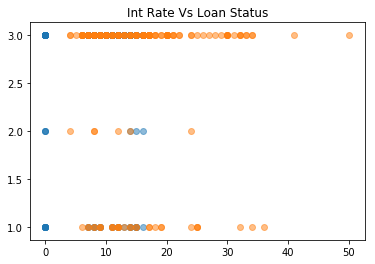

In [127]:
N = 50
plt.scatter(x1, y, alpha=0.5)
plt.scatter(x2, y, alpha=0.5)
plt.title('Int Rate Vs Loan Status')
plt.show()

### Convert Data Set to Labeled Points

A LabeledPoint is a MLlib structure that is used to train the machine learning
models. It consists of two attributes: label and features

#### Splitting into training and testing

In [131]:
loan_train, loan_test = finaldataloan.randomSplit([0.7, 0.3])
loan_train.show(5)

+---------------+--------+---------+-------------+------------+-----------+--------------+---------------+----------------+---------------+----------------+-----------------+--------------+---------+--------------------+-------------+---------------+
|loan_status_int|term_int|grade_int|homeowner_int|veri_sta_int|purpose_int|emp_length_int|loan_amnt_strat|annual_inc_strat|revol_bal_strat|revol_util_strat|total_pymnt_strat|int_rate_strat|dti_strat|inq_last_6mths_strat|pub_rec_strat|total_acc_strat|
+---------------+--------+---------+-------------+------------+-----------+--------------+---------------+----------------+---------------+----------------+-----------------+--------------+---------+--------------------+-------------+---------------+
|              0|       1|        1|            0|           1|          1|             3|              3|              28|              0|               1|                8|             8|        4|                   1|            1|             

#### Predicting Loan Status through Logistic Regression

In [132]:
import pyspark.ml.classification as cl
import pyspark.ml.feature as ft
from pyspark.ml import Pipeline
import pyspark.sql.types as typ

In [136]:
inputlabel=["term_int","grade_int","homeowner_int","veri_sta_int","purpose_int","emp_length_int","loan_amnt_strat","annual_inc_strat","revol_bal_strat","revol_util_strat","total_pymnt_strat","int_rate_strat","dti_strat","inq_last_6mths_strat","pub_rec_strat","total_acc_strat"]
outputlabel=["loan_status_int"]
encoder = ft.OneHotEncoder(inputCol='term_int',outputCol='term_vec')
featuresCreator = ft.VectorAssembler(inputCols=inputlabel,outputCol='features')
logistic = cl.LogisticRegression(maxIter=10,regParam=0.01,labelCol='loan_status_int')
pipeline = Pipeline(stages=[encoder,featuresCreator,logistic])

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/pyspark/ml/wrapper.py", line 105, in __del__
    SparkContext._active_spark_context._gateway.detach(self._java_obj)
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'


In [137]:
model = pipeline.fit(loan_train)
test_model = model.transform(loan_test)

In [138]:
test_model.take(1)

[Row(loan_status_int=0, term_int=1, grade_int=1, homeowner_int=0, veri_sta_int=1, purpose_int=0, emp_length_int=2, loan_amnt_strat=2, annual_inc_strat=12, revol_bal_strat=1, revol_util_strat=0, total_pymnt_strat=1, int_rate_strat=9, dti_strat=0, inq_last_6mths_strat=0, pub_rec_strat=3, total_acc_strat=1, term_vec=SparseVector(2, {1: 1.0}), features=DenseVector([1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 12.0, 1.0, 0.0, 1.0, 9.0, 0.0, 0.0, 3.0, 1.0]), rawPrediction=DenseVector([-1.0614, 2.5037, -0.059, 5.1424, -2.8419, -2.3397, -1.3441]), probability=DenseVector([0.0019, 0.0661, 0.0051, 0.9247, 0.0003, 0.0005, 0.0014]), prediction=3.0)]

### Evaluating the performance of the model

In [139]:
import pyspark.ml.evaluation as ev

The BinaryClassficationEvaluator is used to test how well our model performed

In [140]:
evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='loan_status_int')

The performance of the model

In [141]:
print(evaluator.evaluate(test_model,{evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(test_model,{evaluator.metricName: 'areaUnderPR'}))

0.6256140798649927
0.9899859027896035


The area under the ROC of 62.56% and area under PR of 98.99% shows a well-defined
model.

### Saving the model

#### Save the Pipeline

In [142]:
pipelinePath = 'LoanStatus_Logistic_Pipeline'
pipeline.write().overwrite().save(pipelinePath)

In [144]:
loadedPipeline = Pipeline.load(pipelinePath)
loadedPipeline.fit(loan_train).transform(loan_test).take(1)

[Row(loan_status_int=0, term_int=1, grade_int=1, homeowner_int=0, veri_sta_int=1, purpose_int=0, emp_length_int=2, loan_amnt_strat=2, annual_inc_strat=12, revol_bal_strat=1, revol_util_strat=0, total_pymnt_strat=1, int_rate_strat=9, dti_strat=0, inq_last_6mths_strat=0, pub_rec_strat=3, total_acc_strat=1, term_vec=SparseVector(2, {1: 1.0}), features=DenseVector([1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 12.0, 1.0, 0.0, 1.0, 9.0, 0.0, 0.0, 3.0, 1.0]), rawPrediction=DenseVector([-1.0614, 2.5037, -0.059, 5.1424, -2.8419, -2.3397, -1.3441]), probability=DenseVector([0.0019, 0.0661, 0.0051, 0.9247, 0.0003, 0.0005, 0.0014]), prediction=3.0)]

#### Save the model

In [145]:
from pyspark.ml import PipelineModel
modelPath = 'LoanStatus_Logistic_PipelineModel'
model.write().overwrite().save(modelPath)
loadedPipelineModel = PipelineModel.load(modelPath)
test_reloadedModel = loadedPipelineModel.transform(loan_test)

In [146]:
test_reloadedModel.take(1)

[Row(loan_status_int=0, term_int=1, grade_int=1, homeowner_int=0, veri_sta_int=1, purpose_int=0, emp_length_int=2, loan_amnt_strat=2, annual_inc_strat=12, revol_bal_strat=1, revol_util_strat=0, total_pymnt_strat=1, int_rate_strat=9, dti_strat=0, inq_last_6mths_strat=0, pub_rec_strat=3, total_acc_strat=1, term_vec=SparseVector(2, {1: 1.0}), features=DenseVector([1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 12.0, 1.0, 0.0, 1.0, 9.0, 0.0, 0.0, 3.0, 1.0]), rawPrediction=DenseVector([-1.0614, 2.5037, -0.059, 5.1424, -2.8419, -2.3397, -1.3441]), probability=DenseVector([0.0019, 0.0661, 0.0051, 0.9247, 0.0003, 0.0005, 0.0014]), prediction=3.0)]